In [60]:
import pandas as pd, gc
import numpy  as np

import matplotlib.pyplot as plt

train  = pd.read_csv("train.csv")
test   = pd.read_csv("test.csv")
submit = pd.read_csv("solution_format.csv")

train.shape, test.shape, submit.shape

((5250, 1201), (2250, 1201), (2250, 2))

- labels: target variable with 0 being 'real', and 1 being 'fake'

In [2]:
train["labels"].value_counts()

0    3850
1    1400
Name: labels, dtype: int64

# CROSS VALIDATION

In [93]:
%%time

import warnings

warnings.simplefilter("ignore")

import lightgbm as lgb
import xgboost  as xgb
import catboost as cat

from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold

lgb_params = {
    "objective"             : "binary",
    "metric"                : "binary_logloss",
    "learning_rate"         :  0.01,
    "n_estimators"          :  1000,
    "random_state"          :  2023,
    "importance_type"       : "gain"
}

xgb_params = {
    'objective'            : 'binary:logistic',
    'eval_metric'          : 'logloss',
    'learning_rate'        :  0.01,
    'n_estimators'         :  1000,
    'random_state'         :  2023
}

cat_params = {
    "objective"               : "CrossEntropy",
    "learning_rate"           : 0.01,
    "n_estimators"            : 1000
   
}

fold = 5

skf = list(StratifiedKFold(n_splits=fold, random_state=2023, shuffle=True).split(X=train, y=train["labels"]))
oof = pd.DataFrame(np.zeros((len(train), )))

df_imp  = pd.DataFrame()
models  = {}

for i, (tr_i, va_i) in tqdm(enumerate(skf)):
    print('Fold:', i+1)
    
    # training data
    train_x = train.iloc[tr_i, 1:]
    valid_x = train.iloc[va_i, 1:]
    
    # label data
    train_y = train.iloc[tr_i, 0]
    valid_y = train.iloc[va_i, 0]
    
    # model
#     model = lgb.LGBMClassifier(**lgb_params)
    model = xgb.XGBClassifier(**xgb_params)
#     model = cat.CatBoostClassifier(**cat_params)
    
    model.fit(train_x, train_y,
              eval_set=[(valid_x, valid_y)],
              early_stopping_rounds=20,
              verbose=0)
    
    # SAVE MODEL, PREDICT VALID OOF
    models[f"FOLD{i}:"] = model
    
    predict = model.predict_proba(valid_x)[:,0]
    
    oof.loc[va_i, 0] = predict

0it [00:00, ?it/s]

Fold: 1


1it [03:52, 232.11s/it]

Fold: 2


2it [09:14, 285.23s/it]

Fold: 3


3it [13:33, 273.14s/it]

Fold: 4


4it [18:39, 286.30s/it]

Fold: 5


5it [23:07, 277.41s/it]

CPU times: user 1h 16min 43s, sys: 14.7 s, total: 1h 16min 58s
Wall time: 23min 7s


In [94]:
from sklearn.metrics import f1_score

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores     = []
thresholds = []

best_score     = 0
best_threshold = 0

for threshold in np.arange(0.4, 0.8, 0.01):
    preds = (oof.values.reshape(-1) < threshold).astype("int")
    score = f1_score(train["labels"].values.reshape(-1), preds, average="macro")
    
    scores.append(score)
    thresholds.append(threshold)
    
    if score > best_score:
        best_score = score
        best_threshold = threshold

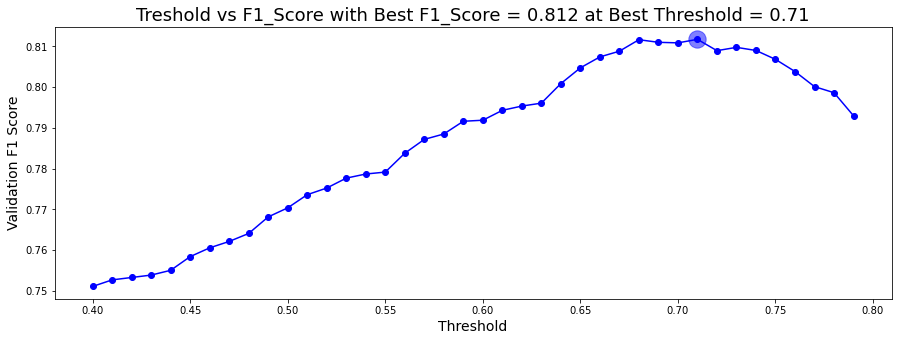

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(thresholds, scores, "-o", color="blue")
plt.scatter([best_threshold], [best_score], color="blue", s=300, alpha=0.5)
plt.xlabel("Threshold", size=14)
plt.ylabel("Validation F1 Score", size=14)
plt.title(f"Treshold vs F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}", size=18)
plt.show()

In [96]:
# COMPUTE F1 SCORE OVERALL
score = f1_score(train["labels"].values, (oof.values.reshape(-1) < best_threshold).astype('int'), average='macro')
print('==> Overall F1 =', score)

# ==> Overall F1 = 0.8143067375264466: LGB Best Threshold = 0.72
# ==> Overall F1 = 0.8117304611197682: XGB Best Threshold = 0.71
# ==> Overall F1 = 0.8331520382188877: CAT Best Threshold = 0.68

==> Overall F1 = 0.8117304611197682


In [97]:
x_test = test.iloc[:,1:]

p_proba_test = 0

for key in models.keys():
    p_proba_test += models[key].predict_proba(x_test)[:,0]

p_proba_test /= fold
p_test        = (p_proba_test < best_threshold).astype(int)

In [82]:
submit["labels"] = p_test

# final submission
submit.iloc[:,:2].to_csv("submission.csv", index=False)

In [92]:
# submit["labels_lgb_proba"] = p_proba_test
# submit["labels_lgb"]       = p_test

In [98]:
# submit["labels_xgb_proba"] = p_proba_test
# submit["labels_xgb"]       = p_test

In [86]:
# submit["labels_cat_proba"] = p_proba_test
# submit["labels_cat"]       = p_test

In [99]:
submit["labels"] = ((submit["labels_lgb"] + submit["labels_xgb"] + submit["labels_cat"]) >= 1).astype(int)

# final submission
submit.iloc[:,:2].to_csv("submission_ensemble.csv", index=False)

In [4]:
threshold = 2.2

submit["labels"] = ((submit["labels_cat_proba"] + submit["labels_lgb_proba"] + submit["labels_xgb_proba"]) < threshold).astype(int)

submit.iloc[:,:2].to_csv("submission_ensemble4.csv", index=False)